In [1]:
# initialization
import matplotlib.pyplot as plt
import numpy as np
import random

# importing Qiskit
from qiskit import IBMQ, Aer, execute
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.quantum_info import Statevector

# import basic plot tools
from qiskit.visualization import plot_histogram

In [2]:
n = 3 # number of qubits used to represent s

s = '010'   # the hidden binary string

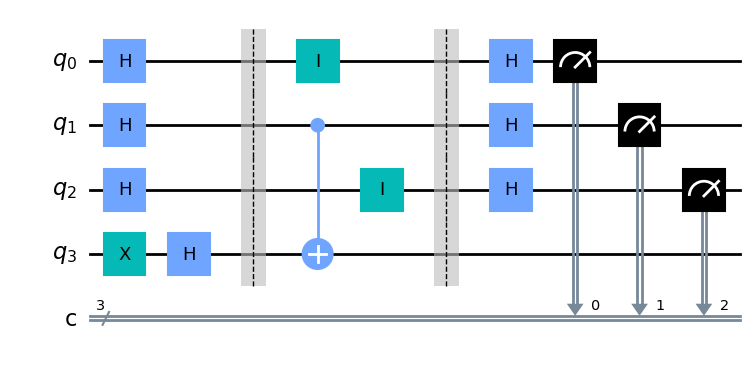

In [3]:
# Circuit with n qubits + 1 output qubit
# n classical bits to write to
circuit = QuantumCircuit(n+1, n)

# Apply Hadamard gates 
circuit.h(range(n))

# qubit in |-> state
circuit.x(n)
circuit.h(n)

ket = Statevector(circuit)
ket.draw()

circuit.barrier()

# Apply cx gate else, i gate
for i, b in enumerate(reversed(s)): # reverse s to fit qiskit's qubit ordering
    if b == '1':
        circuit.cx(i, len(s))
    else:
        circuit.i(i)
        
circuit.barrier()

# Apply Hadamard gates again
circuit.h(range(n))

# Measure
circuit.measure(range(len(s)), range(len(s)))
circuit.draw(output='mpl')

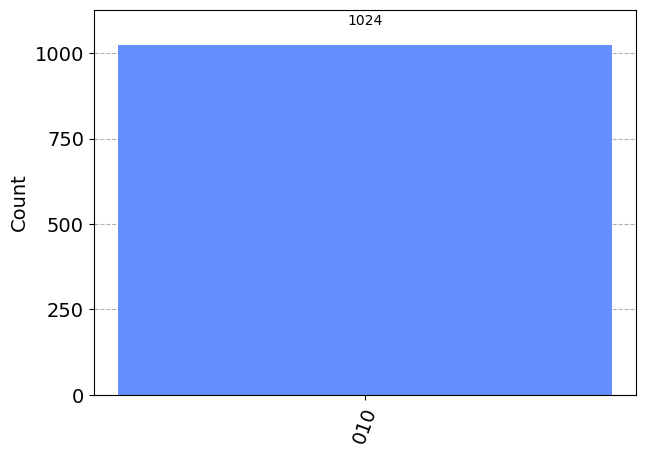

In [4]:
simulator = Aer.get_backend('qasm_simulator')
sim_result= execute(circuit, backend=simulator, shots= 1024).result()

plot_histogram(sim_result.get_counts(circuit))

In [5]:
# Load saved IBMQ account and device
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
device = provider.get_backend('ibmq_belem')

In [6]:
from qiskit.tools.monitor import job_monitor

job = execute(circuit, backend=device, shots=1024)
print(job.job_id())

job_monitor(job)

639bccaeab522a270810bb39
Job Status: job has successfully run


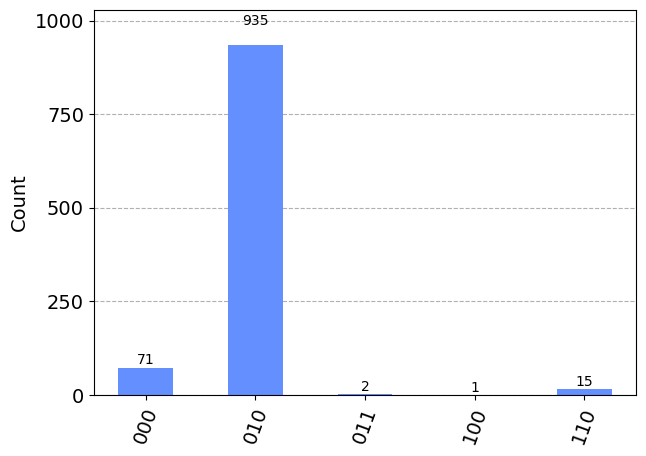

In [7]:
# Get the results from the computation
device_results = job.result()

plot_histogram(device_results.get_counts(circuit))

In [9]:
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter)
cal_circuit, state_label = complete_meas_cal(qr = QuantumRegister(3), 
                                             circlabel = 'measerrormitigational')

In [12]:
# run calibrate job
cal_job = execute(cal_circuit, backend=device, shots= 1024, optimization_level=0)
print(cal_job.job_id())
job_monitor(cal_job)
cal_result = cal_job.result()

639bccccd2a97b5d95a294c3
Job Status: job has successfully run


In [16]:
meas_fitter = CompleteMeasFitter(cal_result, state_label)

In [18]:
meas_filter = meas_fitter.filter

In [19]:
mitigated_result = meas_filter.apply(device_results)

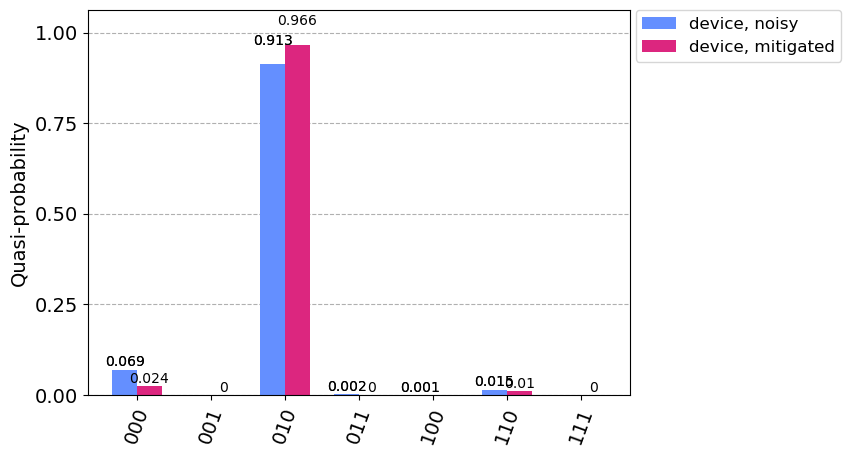

In [21]:
# compare before and after mitigate the noise
device_count = device_results.get_counts(circuit)
mitigated_count = mitigated_result.get_counts(circuit)
plot_histogram([device_count, mitigated_count], legend=['device, noisy', 'device, mitigated'])